In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm
import time
import gc

# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear GPU cache
torch.cuda.empty_cache()
gc.collect()

# Define data augmentation and preprocessing
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset with proper num_workers for Colab
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128,
                        shuffle=True, num_workers=2,
                        pin_memory=True)  # Enable pin_memory for faster data transfer to GPU

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=128,
                       shuffle=False, num_workers=2,
                       pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:18<00:00, 9.19MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
import torchvision.models as models

def create_resnet_transfer():
    # Load pretrained ResNet18
    model = models.resnet18(pretrained=True)

    # Freeze all the pretrained layers
    for param in model.parameters():
        param.requires_grad = False

    # Modify the final fully connected layer for CIFAR-10 (10 classes)
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, 10)
    )

    return model.to(device)

# Create the model
model = create_resnet_transfer()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Only optimize parameters of the new classifier layers (model.fc)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Training function
def train_epoch(model, trainloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(trainloader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Evaluation function
def evaluate(model, testloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss = running_loss / len(testloader)
    test_acc = 100. * correct / total
    return test_loss, test_acc

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]



Epoch 1/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.8441, Training Accuracy: 34.23%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.7119, Validation Accuracy: 39.23%

Epoch 2/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.7355, Training Accuracy: 38.14%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.6720, Validation Accuracy: 41.39%

Epoch 3/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.7109, Training Accuracy: 39.21%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.6587, Validation Accuracy: 41.54%

Epoch 4/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6939, Training Accuracy: 39.56%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.6223, Validation Accuracy: 42.90%

Epoch 5/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6853, Training Accuracy: 39.87%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.6351, Validation Accuracy: 41.89%

Epoch 6/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6806, Training Accuracy: 40.67%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.6350, Validation Accuracy: 42.27%

Epoch 7/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6701, Training Accuracy: 40.82%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.6018, Validation Accuracy: 43.36%

Epoch 8/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6603, Training Accuracy: 41.02%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.6131, Validation Accuracy: 43.04%

Epoch 9/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6644, Training Accuracy: 40.92%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.6008, Validation Accuracy: 43.75%

Epoch 10/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6578, Training Accuracy: 41.13%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.5836, Validation Accuracy: 44.30%

Epoch 11/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6526, Training Accuracy: 41.48%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.5832, Validation Accuracy: 44.00%

Epoch 12/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6517, Training Accuracy: 41.39%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.5842, Validation Accuracy: 43.96%

Epoch 13/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6540, Training Accuracy: 41.46%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.5816, Validation Accuracy: 43.52%

Epoch 14/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6427, Training Accuracy: 41.65%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.5935, Validation Accuracy: 43.75%

Epoch 15/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6402, Training Accuracy: 41.84%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.5901, Validation Accuracy: 43.18%

Epoch 16/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6379, Training Accuracy: 41.89%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.5827, Validation Accuracy: 42.91%

Epoch 17/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6348, Training Accuracy: 41.96%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.5696, Validation Accuracy: 44.14%

Epoch 18/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6336, Training Accuracy: 41.91%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.5758, Validation Accuracy: 43.70%

Epoch 19/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6349, Training Accuracy: 41.96%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.5785, Validation Accuracy: 43.47%

Epoch 20/20


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Training Loss: 1.6304, Training Accuracy: 42.05%


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Validation Loss: 1.5627, Validation Accuracy: 44.72%

Best Validation Accuracy: 44.72%


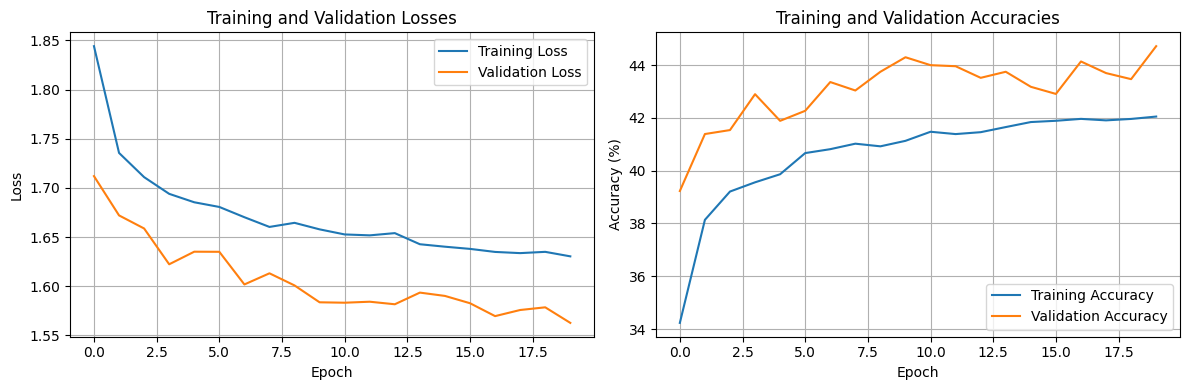

In [3]:
import matplotlib.pyplot as plt

# Lists to store metrics
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop with metrics tracking
num_epochs = 20
best_acc = 0.0

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')

    # Train
    train_loss, train_acc = train_epoch(model, trainloader, criterion, optimizer)
    print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%')

    # Evaluate
    val_loss, val_acc = evaluate(model, testloader, criterion)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet_transfer.pth')

print(f'\nBest Validation Accuracy: {best_acc:.2f}%')

# Plotting
plt.figure(figsize=(12, 4))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Save the plots
plt.savefig('training_plots.png')
plt.close()

Evaluating model performance...


Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]


Classification Report:
              precision    recall  f1-score   support

       plane      0.455     0.532     0.490      1000
         car      0.477     0.572     0.520      1000
        bird      0.393     0.314     0.349      1000
         cat      0.387     0.291     0.332      1000
        deer      0.425     0.511     0.464      1000
         dog      0.394     0.437     0.415      1000
        frog      0.500     0.580     0.537      1000
       horse      0.457     0.446     0.452      1000
        ship      0.469     0.438     0.453      1000
       truck      0.500     0.351     0.412      1000

    accuracy                          0.447     10000
   macro avg      0.446     0.447     0.442     10000
weighted avg      0.446     0.447     0.442     10000


Plotting confusion matrix...


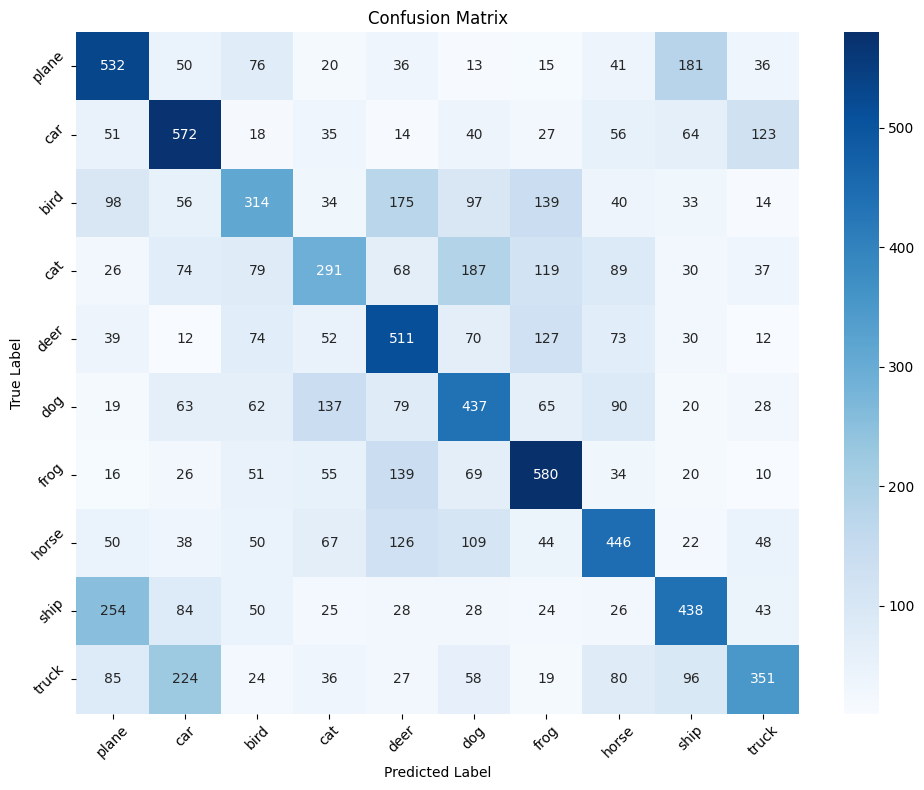


Visualizing predictions on test images...


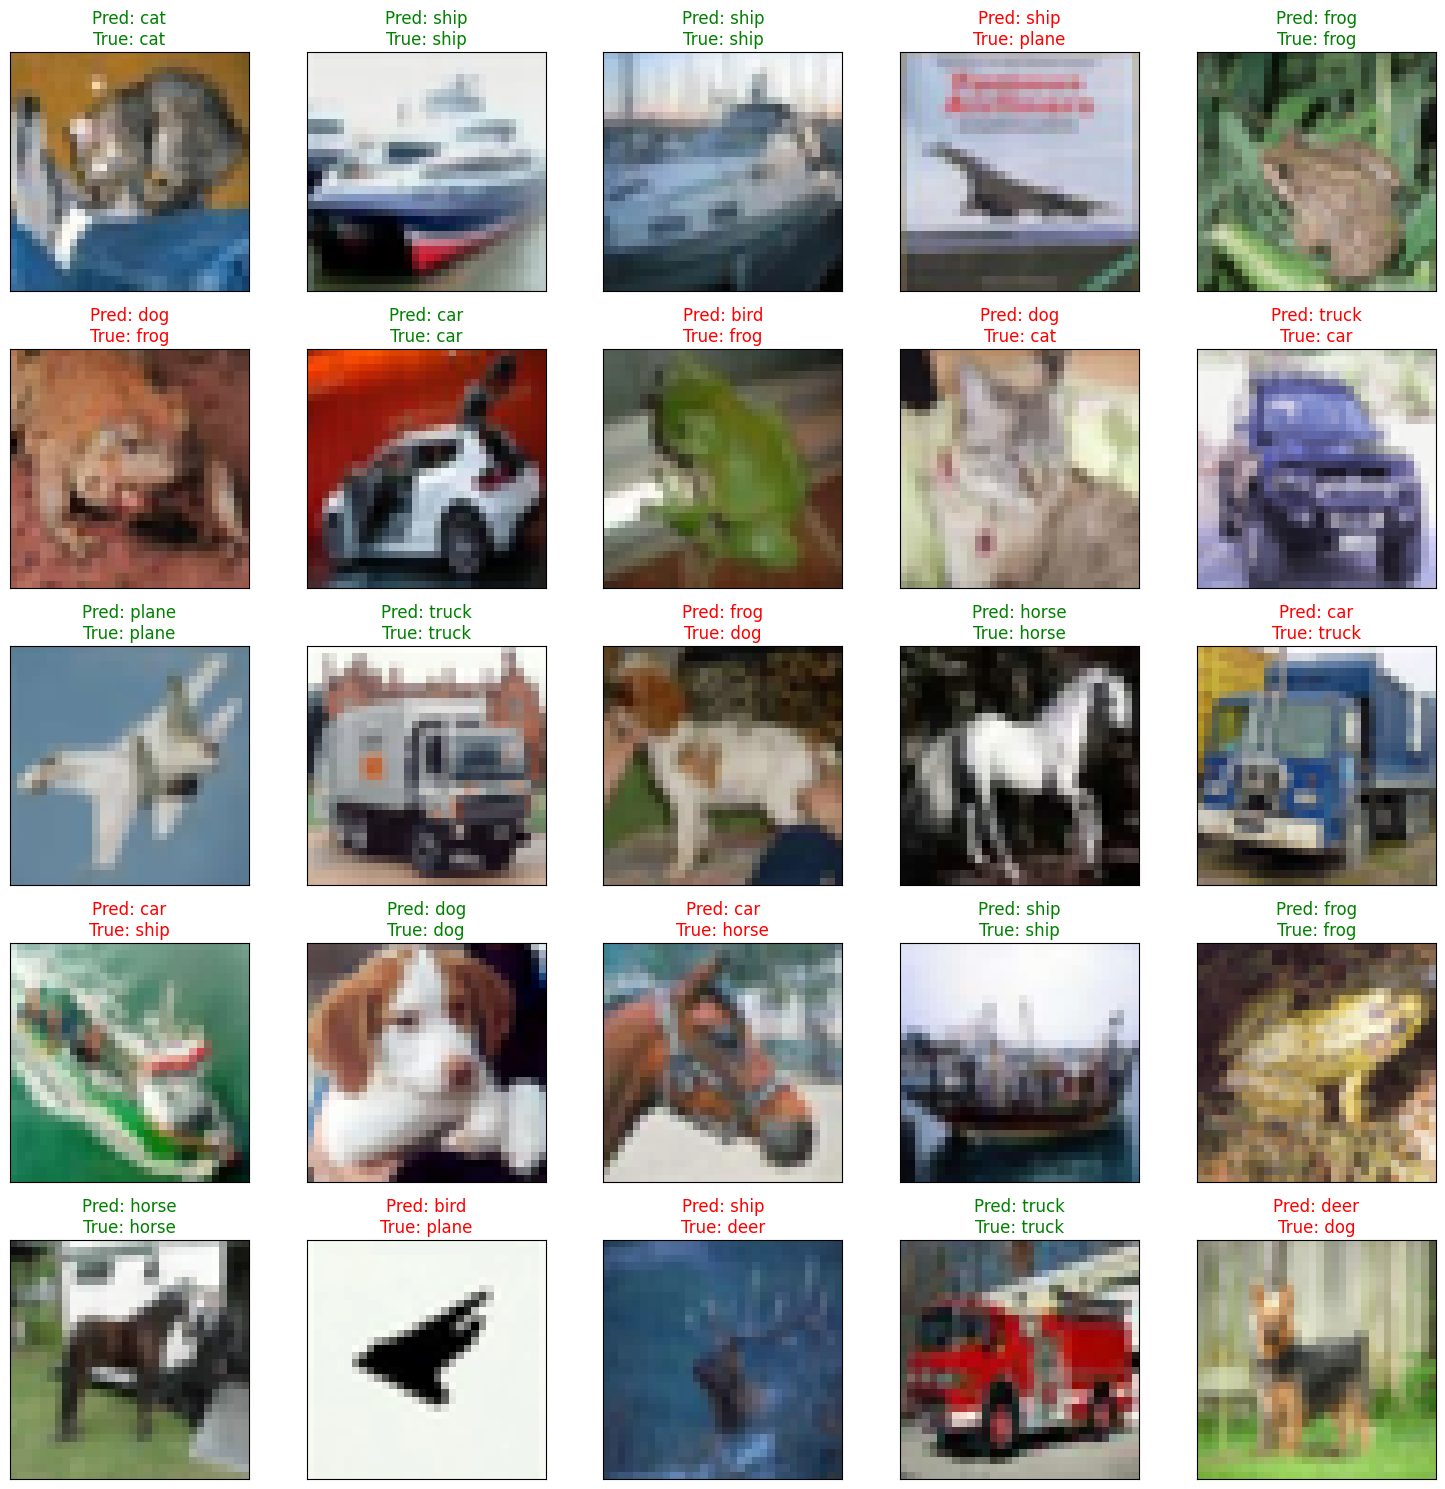


Overall Accuracy: 0.447


In [4]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def evaluate_model(model, testloader, classes):
    """
    Evaluate the model and compute various metrics
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Collect predictions and labels
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Get classification report
    report = classification_report(all_labels, all_preds,
                                 target_names=classes,
                                 digits=3)

    return cm, report, all_preds, all_labels

def plot_confusion_matrix(cm, classes):
    """
    Plot confusion matrix using seaborn
    """
    plt.figure(figsize=(10, 8))

    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)

    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_predictions(model, testloader, classes, num_images=25):
    """
    Visualize model predictions on test images
    """
    model.eval()

    # Get a batch of test images
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images = images[:num_images]
    labels = labels[:num_images]

    # Get predictions
    with torch.no_grad():
        outputs = model(images.to(device))
        _, predicted = outputs.max(1)

    # Plot images
    fig = plt.figure(figsize=(15, 15))
    for idx in range(num_images):
        ax = fig.add_subplot(5, 5, idx+1, xticks=[], yticks=[])
        img = images[idx].cpu().numpy().transpose((1, 2, 0))

        # Denormalize image
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        ax.imshow(img)

        # Color code: green for correct predictions, red for incorrect
        color = 'green' if predicted[idx] == labels[idx] else 'red'
        ax.set_title(f'Pred: {classes[predicted[idx]]}\nTrue: {classes[labels[idx]]}',
                    color=color)

    plt.tight_layout()
    plt.savefig('prediction_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

# Evaluate the model
print("Evaluating model performance...")
confusion_mat, class_report, predictions, true_labels = evaluate_model(model, testloader, classes)

# Print classification report
print("\nClassification Report:")
print(class_report)

# Plot confusion matrix
print("\nPlotting confusion matrix...")
plot_confusion_matrix(confusion_mat, classes)

# Visualize some predictions
print("\nVisualizing predictions on test images...")
visualize_predictions(model, testloader, classes)

# Calculate and print overall metrics
accuracy = (predictions == true_labels).mean()
print(f"\nOverall Accuracy: {accuracy:.3f}")

# Save detailed results to a file
with open('model_evaluation_results.txt', 'w') as f:
    f.write("Model Evaluation Results\n")
    f.write("=======================\n\n")
    f.write(f"Overall Accuracy: {accuracy:.3f}\n\n")
    f.write("Classification Report:\n")
    f.write(class_report)